# TEMPO Tutorial 1
## Rabi Oscillations in a 2-level System

### Import packages

In [1]:
# Add TEMPO path to searchable directory list
# Edit as needed
dirpath_pers = "/path/to/TEMPO/"

import sys
if dirpath_pers not in sys.path:
    sys.path.insert(0, dirpath_pers)

In [2]:
# Import TEMPO packages
from tempo.hamiltonian    import Hamiltonian
from tempo.pulse_recipe   import Pulse_recipe
from tempo.evolver        import Evolver
from tempo.pulse_sequence import Pulse_sequence
from tempo.pulse          import Pulse

In [3]:
# Non-TEMPO packages
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

## Step 1: Create Pulse Recipe

In [4]:
# Define the time-dependent pulse type of functional form:
#       A*cos(omega*(t+offset)+phase)
# Function must have inputs t, args
def func_X(t, args):
    return args['AMP']*np.cos(2*np.pi*args['FREQ']*t)

# operator to be multiplied by function output
H_X = 2 * np.pi * sigmax()
display(H_X /(2*np.pi))

# parameter names for pulse recipe
keys_X = ['AMP', 'FREQ']

# create the pulsetype object with the operator, parameter names, and function
# we do not input numerical values yet; this pulsetype is a blueprint for any ACD pulse
# values will come later
recipe_X = Pulse_recipe(Hamiltonian(H_X), keys_X, func_X)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

## Step 2: Create Pulse(s)

In [5]:
# Parameters for static Hamiltonian 
E0 = 1000
pars_Hsz = {'coeff': -2*np.pi, 'E': E0}
ops_Hsz = {'SZ': sigmaz()}

# define function for static Hamiltonian
def f_Hsz(ops, pars):
    sz = ops['SZ']
    c = pars['coeff']
    E = pars['E']

    return c * E * sz

In [6]:
# create static Hamiltonian
Hs = Hamiltonian(ops_Hsz, pars_Hsz, f_Hsz)

# extract the static Hamiltonian operator
Hs_op = Hs.H
display(Hs_op /(2*np.pi))

# Calculate eigenenergies
eig_energies = Hs_op.eigenenergies()/2/np.pi

# Resonance frequency of transition
frq_trans =  max(eig_energies) - min(eig_energies)
print("Transition Frequency =", np.round(frq_trans, 3))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[-1000.     0.]
 [    0.  1000.]]

Transition Frequency = 2000.0


In [7]:
# Pulse start time
t0 = .1

# Pulse duration
tpulse = .3

# Amplitude of oscillating field
amp = 12

# Specify parameter values for individual pulse
par_values = {'AMP': amp, 'FREQ': frq_trans}

# Create individual pulse
pulseX = Pulse(recipe_X, 
               start_time = t0, 
               duration = tpulse, 
               coeff_params = par_values)


## Step 3: Create Pulse Sequence

In [8]:
# Define pulse sequence object instance with static Hamiltonian as input
# QuTiP Qobjs are also allowed as input to Hstat
pseq = Pulse_sequence(Hstat = Hs)

# Add pulse to sequence
pseq.add_pulse(pulseX)

## Step 4: Evolve System in Time

In [9]:
# Create array of evaluation times for output
Teval_start = 0
Teval_end = 2*tpulse
Npts_eval = 501
times_eval = np.linspace(Teval_start, Teval_end, Npts_eval)

# Define 2-level system initial state
state_init = basis(2,0) 
display(state_init)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

In [10]:
# Initialize evolver objects (no difference at this point)
ev = Evolver(state_init, times_eval, pseq)

# Run evaluation
result = ev.evolve()

## Plot Results

In [11]:
# Evaluate expectation values of Pauli sigma_z operator
expectations_Z = expect(sigmaz(), result.states)

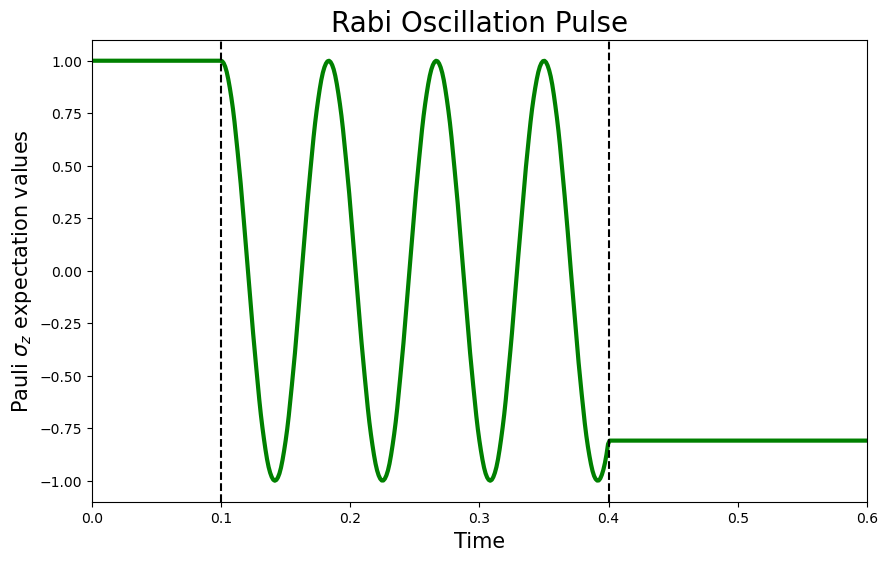

In [12]:
# Create figure
plt.figure(figsize=(10,6))
plt.plot(times_eval, expectations_Z, lw=3, c="green")

# Vertical lines to denote start and end time of pulse
vert_props = dict(color="black", linestyle="--")
plt.axvline(pulseX.start_time, **vert_props)
plt.axvline(pulseX.end_time, **vert_props)

# Title and axes labels
title_font = dict(fontsize=20, weight="normal")
labels_font = dict(fontsize=15, weight="light")
plt.title("Rabi Oscillation Pulse", fontdict=title_font)
plt.xlabel("Time", fontdict=labels_font)
plt.ylabel("Pauli $\sigma_z$ expectation values", fontdict=labels_font)

plt.xlim(min(times_eval), max(times_eval))
plt.show()